# 머신러닝 모델에 사용한 데이터를 딥러닝(mxnet)으로 학습하기

In [1]:
# 토큰 파일 업로드
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dgkim1108","key":"8dfa654b9b5989daeb761e5ffe86e8ba"}'}

In [2]:
%ls kaggle.json

kaggle.json


In [3]:
# json 파일 이동

# Kaggle API 를 사용하기 위해서는 json 파일을 ~/.kaggle로 이동 시키는 작업이 필요합니다.

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json
# 내가 참가한 대회 리스트 확인
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes        213           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        352           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        998           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       6348            True  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      53660            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge      14052            True  
connectx

# 캐글 데이터셋 가져오기

- 캐글 보스턴 주택 가격 예측하기 https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
- 예측 변수 → SalePrice

![](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)

### 위 링크로 이동하여 New Notebook 옆 점 3개를 클릭한 후 Copy API command 선택

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FtK61N%2Fbtq0Dso3Orh%2FcvNBpePyBzTG3t6Nlz7YC0%2Fimg.png)

- 해당 메뉴가 안보일 경우 상단 메뉴에서 Data로 이동한 후 중단 부분에 kaggle cometitions download -c <대회 명칭> 을 복사해서 실행

In [4]:
# 캐글 주택 가격 데이터 가져오기

!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 27.1MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 12.7MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 33.7MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 60.9MB/s]


In [5]:
# 내려받은 데이터 목록 확인
%ls

data_description.txt  sample_data/           test.csv
kaggle.json           sample_submission.csv  train.csv


In [237]:
# 딥러닝 라이브러리 설치
!pip install d2l

     |████████████████████████████████| 92kB 4.4MB/s 


In [256]:
!pip install d2l-zh

  Created wheel for d2l-zh: filename=d2l_zh-0.8.10-cp37-none-any.whl size=10082 sha256=47cefde05a36cd0645ad171a5cf1351c80f4857223e26b10fd8c96f3b88c9258
  Stored in directory: /root/.cache/pip/wheels/e6/dd/e1/5aeff161f79f507f75d821fe945000f6b768831568f777a359
Successfully built d2l-zh


In [280]:
!pip install d2lzh

  Created wheel for d2lzh: filename=d2lzh-1.0.0-cp37-none-any.whl size=10054 sha256=3847eb7620a9f747626f852c9771b0e9953bf6493211fcefe36956bb335a57cc
  Stored in directory: /root/.cache/pip/wheels/13/1c/a3/b00e9d91505a5ab745de5ebd4a141f2dd7802f39e4940ca775
Successfully built d2lzh


In [239]:
!pip install mxnet

     |████████████████████████████████| 46.9MB 59kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [281]:
# 라이브러리 사용
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 딥러닝 모델

import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

In [282]:
# 데이터 불러오기
train = pd.read_csv('train.csv')
print(train.shape)
train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [283]:
# 테스트 데이터 불러오기
test = pd.read_csv('test.csv')
print(test.shape)
test.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### 변수 설명

집에 대한 특징 값들과 도로 종류, 지어진 연도, 지붕 형태, 지하실 상태 등에 대한 속성이 포함되어 있습니다.

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FsVcpQ%2FbtqEC9efaIr%2FRH7eCOHe2xXhpt8D1d2Uh0%2Fimg.png)

# 데이터 전처리

In [284]:
# 불필요 데이터 삭제
all_features = pd.concat((train.iloc[:, 1:-1], test.iloc[:, 1:]))

In [285]:
# 스케일 조정 및 결측값 채우기
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features = all_features.fillna(0)

In [286]:
# 원핫인코딩
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 354)

# 학습 데이터 생성

In [287]:
# 딥러닝 학습이 가능하도록 데이터셋 변경
n_train = train.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train.SalePrice.values).reshape((-1, 1))

# 학습 모델 생성

In [288]:
# 베이스 모델
loss = gloss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

In [289]:
# loss 함수 정의
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()

In [290]:
# 훈련 모델
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
    # The Adam optimization algorithm is used here
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [291]:
# 교차 검증
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

In [292]:
# 학습 오류 검증
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse', range(1, num_epochs + 1), valid_ls, ['train', 'valid'])
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

# 모델 학습

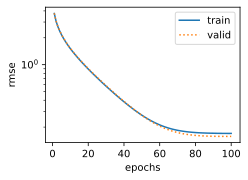

fold 0, train rmse: 0.170014, valid rmse: 0.157455
fold 1, train rmse: 0.162013, valid rmse: 0.189150
fold 2, train rmse: 0.163539, valid rmse: 0.167995
fold 3, train rmse: 0.167430, valid rmse: 0.154404
fold 4, train rmse: 0.162501, valid rmse: 0.182759
5-fold validation: avg train rmse: 0.165099, avg valid rmse: 0.170353


In [293]:
# 학습
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))

- 학습 오류는 작아지지만, 교차검증 결과는 크게 나타나기 때문에 감소하고 있는지를 확인하는 과정이 필요합니다.
- 이번 학습 모델에서는 오버피팅 과정은 제외하며, 이런 방법이 있다는 것을 보여주는 것에 초점을 맞춥니다.

# 예측하기

머신러닝 모델의 fit 함수로 학습을 시킵니다.

학습할 때는 1) train 데이터의 feature인 X_train, 그리고 2) train 데이터의 label인 y_train이 필요합니다.

In [294]:
# 학습 모델을 테스트셋에 적용하여 캐글에 제출할 데이터 생성하기
def train_and_pred(train_features, test_feature, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    # Apply the network to the test set
    preds = net(test_features).asnumpy()
    # Reformat it for export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

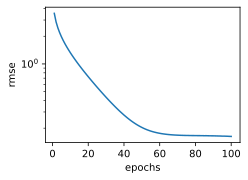

train rmse 0.162625


In [296]:
# 모델 수행
train_and_pred(train_features, test_features, train_labels, test, num_epochs, lr, weight_decay, batch_size)

- 위 차트가 나타나면 submission.csv 파일이 같이 생성됨

# 모델 제출하기

예측 후 캐글(kaggle)이 권장하는 제출(submission) 포멧에 맞게 정리한 뒤 파일로 저장하는 것만 남았습니다.

캐글에서는 train.csv 데이터와 test.csv 데이터 외에 sample_submission.csv라는 제출 포멧을 제공합니다.

In [297]:
%ls

data_description.txt  sample_data/           submission.csv  train.csv
kaggle.json           sample_submission.csv  test.csv


In [298]:
# 캐글이 제공하는 제출 포멧(sampleSubmission.csv)을 읽어옵니다.
submission = pd.read_csv('submission.csv')
submission.head()

,Id,SalePrice
0,1461,119511.99
1,1462,153841.23
2,1463,198519.31
3,1464,217014.88
4,1465,177411.38


In [ ]:
# 예측 결과 다운로드하기
result.to_csv('submission_v0.1_20210712.csv', index=False)

# 코랩과 구글드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 내 드라이브 확인
%cd /content/
!ls drive/MyDrive/

/content
 회사   개인   크몽  'Colab Notebooks'	 docker-crawling   Software


In [ ]:
# 현재 위치 확인
%pwd

'/content'

### 파일 경로 복사 후 코랩에서 데이터 사용 가능

![](https://t1.daumcdn.net/cfile/tistory/995FA7365F7304D816)

In [ ]:
# 구글 드라이브로 데이터 다운로드
result.to_csv('/content/drive/MyDrive/Colab Notebooks/data/submission_v0.1_20210708.csv', index=False)

In [ ]:
# 구글 드라이브에서 데이터 확인하기
pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/submission_v0.1_20210708.csv')

,Id,SalePrice
0,1461,-5.502017e+09
1,1462,-8.376119e+09
2,1463,-4.952588e+09
3,1464,-8.498190e+09
4,1465,-2.000122e+10
...,...,...
1454,2915,-3.442724e+10
1455,2916,-3.064015e+10
1456,2917,-7.509451e+09
1457,2918,-2.768407e+10
